<a href="https://colab.research.google.com/github/jinrumiao/titanic-analysis/blob/main/%E5%B0%88%E9%A1%8C%E5%AF%A6%E4%BD%9C_01%EF%BC%9A%E9%90%B5%E9%81%94%E5%B0%BC%E8%99%9F%E5%AD%98%E6%B4%BB%E9%A0%90%E6%B8%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [79]:
import pandas as pd
import numpy as np

1. 在你的 Colab 程式碼中載入 Titanic 資料集的 `train.csv` 資料集，可以參考這一篇 教學 中的網址或上傳方法。

（資料網址：https://raw.githubusercontent.com/dsindy/kaggle-titanic/master/data/train.csv）

In [80]:
# 載入csv
df = pd.read_csv('https://raw.githubusercontent.com/dsindy/kaggle-titanic/master/data/train.csv')

df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


2. 請根據 Kaggle 文件瞭解 Titanic 資料中所有欄位的定義為何？

 0   PassengerId：ID

 1   Survived：是否存活，0→否、1→是

 2   Pclass：艙等

 3   Name：姓名

 4   Sex：性別

 5   Age：年齡

 6   SibSp：同時登船的兄弟姊妹以及配偶數量

 7   Parch：同時登船的父母以及子女數量

 8   Ticket：船票編號

 9   Fare：票價

 10  Cabin：房間編號

 11  Embarked：登船港口，C→Cherbourg、Q→Queenstoen、S→Southanpton

             PassengerId  Survived    Pclass       Age     SibSp     Parch  \
PassengerId     1.000000 -0.005007 -0.035144  0.036847 -0.057527 -0.001652   
Survived       -0.005007  1.000000 -0.338481 -0.077221 -0.035322  0.081629   
Pclass         -0.035144 -0.338481  1.000000 -0.369226  0.083081  0.018443   
Age             0.036847 -0.077221 -0.369226  1.000000 -0.308247 -0.189119   
SibSp          -0.057527 -0.035322  0.083081 -0.308247  1.000000  0.414838   
Parch          -0.001652  0.081629  0.018443 -0.189119  0.414838  1.000000   
Fare            0.012658  0.257307 -0.549500  0.096067  0.159651  0.216225   

                 Fare  
PassengerId  0.012658  
Survived     0.257307  
Pclass      -0.549500  
Age          0.096067  
SibSp        0.159651  
Parch        0.216225  
Fare         1.000000  


<ipython-input-81-d59df5788067>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  matrix = df.corr()


<Axes: >

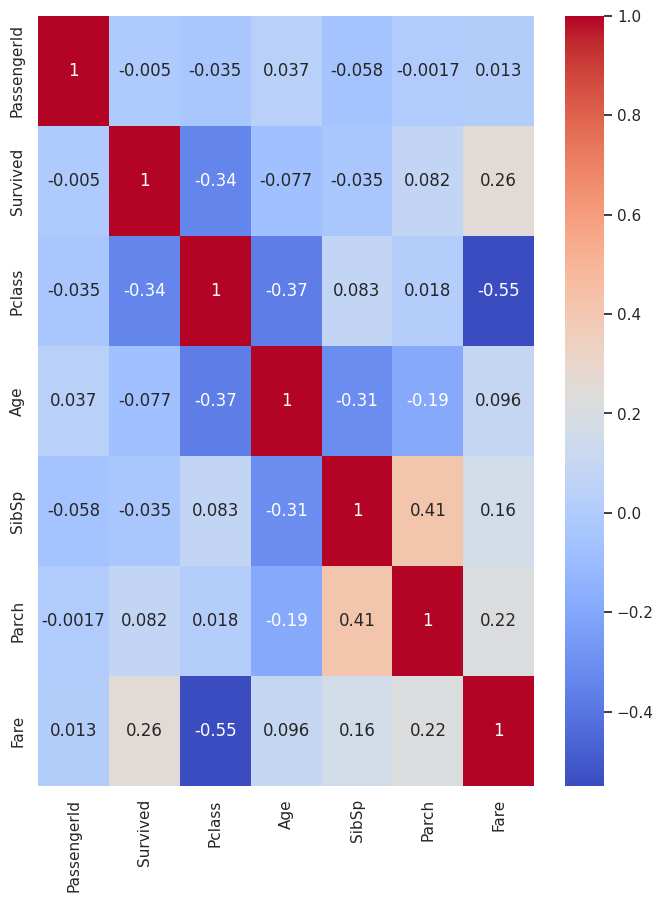

In [81]:
import seaborn as sns

matrix = df.corr()
print(matrix)

sns.heatmap(matrix, annot=True, cmap='coolwarm')


Pclass分類下未能存活與存活的年齡平均
Survived          0          1
Pclass                        
1         43.695312  35.368197
2         33.544444  25.901566
3         26.555556  20.646118


Sex分類下未能存活與存活的年齡平均
Survived          0          1
Sex                           
female    25.046875  28.847716
male      31.618056  27.276022


Embarked分類下未能存活與存活的年齡平均
Survived          0          1
Embarked                      
C         33.666667  28.973671
Q         30.325000  22.500000
S         30.203966  28.113184




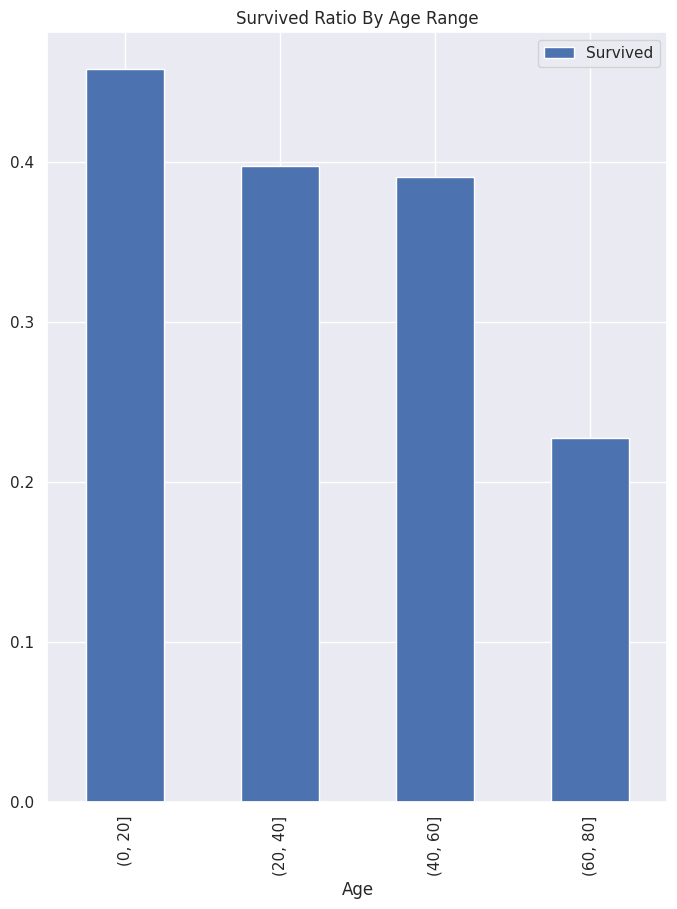

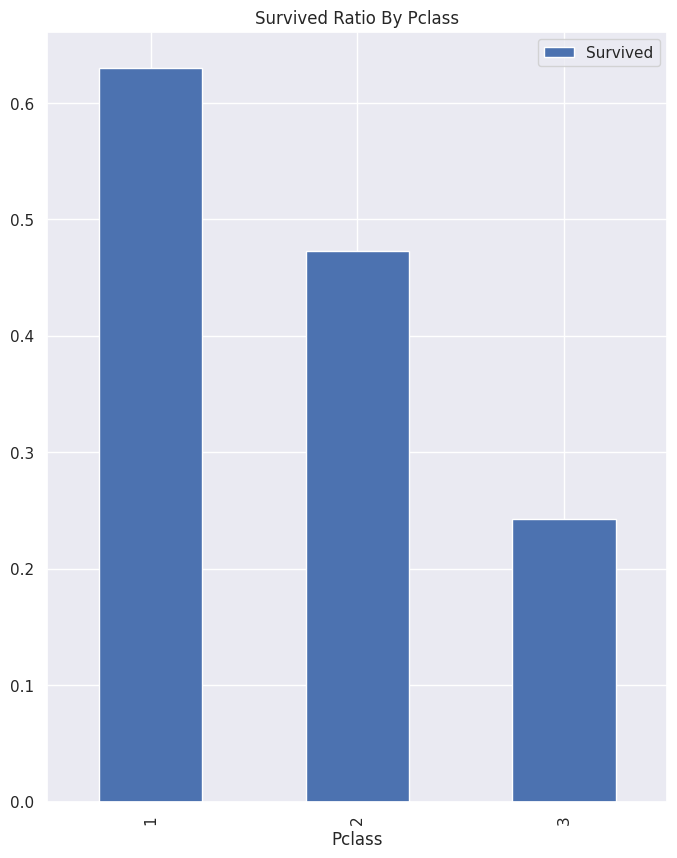

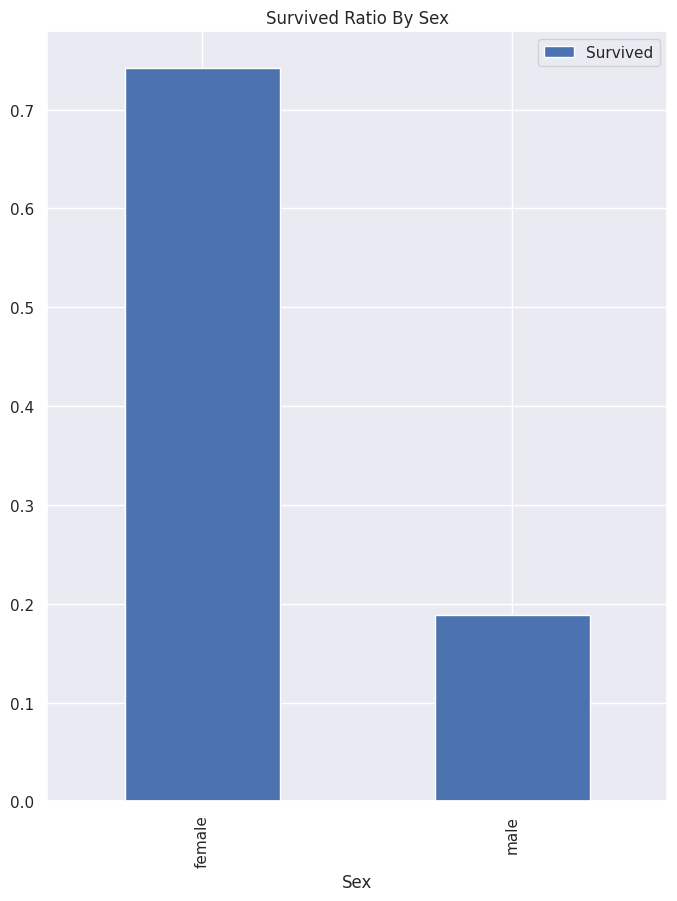

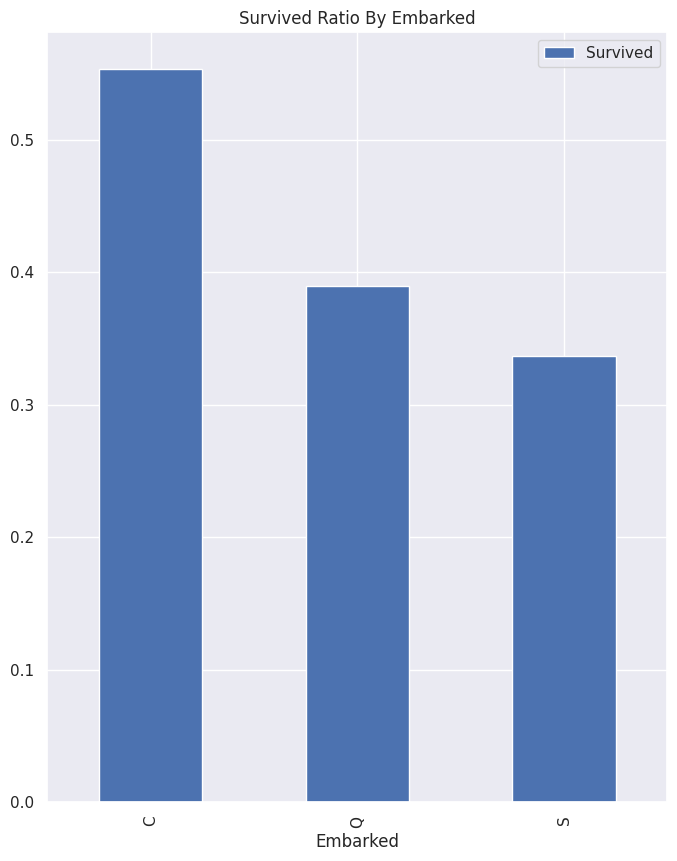

In [82]:
%matplotlib inline
import matplotlib.pyplot as plt
# print(df.columns)
# 先移除比較難看出與存活率有關聯的資訊
clean_df = df.drop(columns=["PassengerId", 'Name', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin'], axis=1)
# print(clean_df.columns)
age = pd.cut(clean_df["Age"], [0, 20, 40, 60, 80])
pd.pivot_table(
    clean_df, index=age, values="Survived", aggfunc=np.mean
    ).plot(
        kind="bar", title="Survived Ratio By Age Range"
            )

for i in range(1, len(clean_df.columns)):
  if clean_df.columns[i] != "Age":
    pd.pivot_table(
        clean_df, index=clean_df.columns[i], values="Survived", aggfunc=np.mean
        ).plot(
            kind="bar", title=f"Survived Ratio By {clean_df.columns[i]}"
            )
    print(f"{clean_df.columns[i]}分類下未能存活與存活的年齡平均")
    print(pd.pivot_table(clean_df, index=clean_df.columns[i], columns="Survived", values="Age", aggfunc=np.mean))
    print("\n")


經過資料前處理後

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [84]:
# 移除對於是否存活沒有意義的特徵：PassengerId、Name、Ticket
df.drop(columns=["PassengerId", "Name", "Ticket"], axis=1, inplace=True, errors="ignore")
# 處理類別型資料：Sex、Cabin、Embarked
df["Sex"] = df["Sex"].map({"male": 0, "female": 1})

df["Cabin"] = df["Cabin"].notnull().astype(int)

df.dropna(subset=["Embarked"], inplace=True)
one_hot_ec = pd.get_dummies(df["Embarked"], prefix="Embarked")
df = pd.concat([df, one_hot_ec], axis=1)
df.drop("Embarked", axis=1, inplace=True)

# 處理數值型資料：Pclass、Age、SibSp、Parch、Fare
from sklearn.preprocessing import StandardScaler

df["Age"].fillna(df["Age"].mean(), inplace=True)

normalize_columns = ["Age", "SibSp", "Parch", "Fare"]
scaler = StandardScaler()
normalized_data = scaler.fit_transform(df[normalize_columns])
normalized_df = pd.DataFrame(normalized_data, columns=normalize_columns)

df[normalize_columns] = normalized_df

df.dropna(how="any", inplace=True)

df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 887 entries, 0 to 888
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    887 non-null    int64  
 1   Pclass      887 non-null    int64  
 2   Sex         887 non-null    int64  
 3   Age         887 non-null    float64
 4   SibSp       887 non-null    float64
 5   Parch       887 non-null    float64
 6   Fare        887 non-null    float64
 7   Cabin       887 non-null    int64  
 8   Embarked_C  887 non-null    uint8  
 9   Embarked_Q  887 non-null    uint8  
 10  Embarked_S  887 non-null    uint8  
dtypes: float64(4), int64(4), uint8(3)
memory usage: 65.0 KB


            Survived  Pclass   Sex   Age  SibSp  Parch  Fare  Cabin  \
Survived        1.00   -0.33  0.54  0.00  -0.08  -0.01  0.01   0.31   
Pclass         -0.33    1.00 -0.13 -0.01   0.01  -0.02 -0.03  -0.72   
Sex             0.54   -0.13  1.00 -0.00  -0.05  -0.03  0.05   0.14   
Age             0.00   -0.01 -0.00  1.00  -0.23  -0.18  0.09   0.04   
SibSp          -0.08    0.01 -0.05 -0.23   1.00   0.41  0.16  -0.04   
Parch          -0.01   -0.02 -0.03 -0.18   0.41   1.00  0.22  -0.02   
Fare            0.01   -0.03  0.05  0.09   0.16   0.22  1.00   0.07   
Cabin           0.31   -0.72  0.14  0.04  -0.04  -0.02  0.07   1.00   
Embarked_C      0.17   -0.24  0.09  0.02  -0.05  -0.04 -0.02   0.21   
Embarked_Q      0.01    0.22  0.08 -0.03  -0.03  -0.06 -0.03  -0.13   
Embarked_S     -0.15    0.08 -0.12  0.00   0.06   0.07  0.03  -0.10   

            Embarked_C  Embarked_Q  Embarked_S  
Survived          0.17        0.01       -0.15  
Pclass           -0.24        0.22        0.08  


<Axes: >

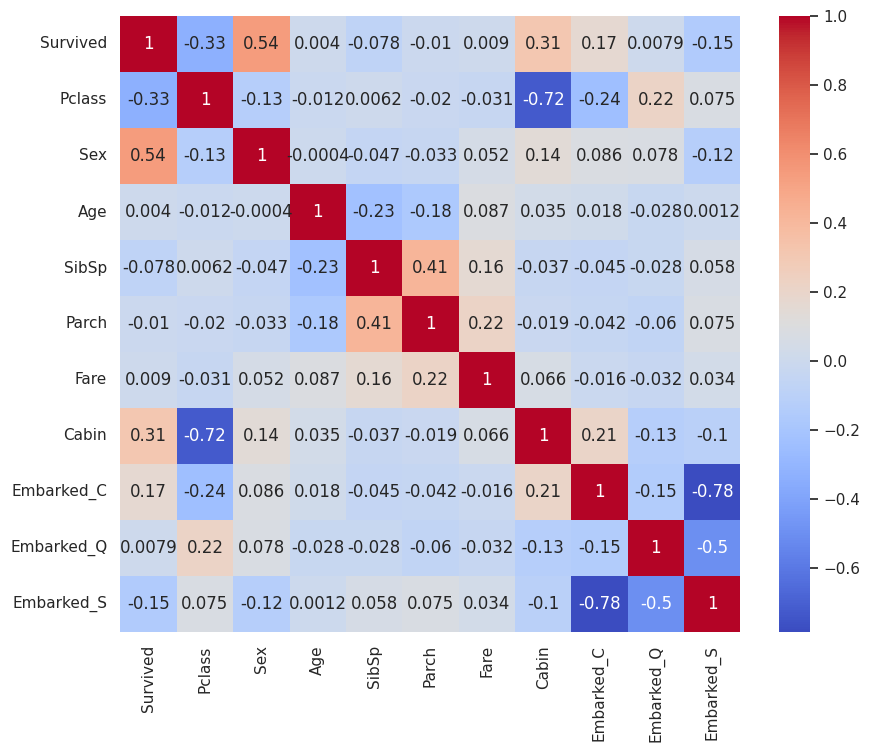

In [85]:
import seaborn as sns

matrix = df.corr()
print(round(matrix, 2))

sns.set(rc={"figure.figsize":(10, 8)})
sns.heatmap(matrix, annot=True, cmap='coolwarm')

3. 進一步觀察每一個欄位「數值欄位/類別欄位」與「是否生存欄位」之關係程度，找出關係大的欄位。

（Hint: 可以利用視覺化圖表、 correlation、feature importance 等方法）




> (1) 在未經過資料前處理的狀態下，直接對資料做corr()，只有發現Pclass對於Survied有較高的負關係，因為資料中包含有類別型的資料，所以並不是全部的特徵都有比較出來，另外透過樞紐分析比較後，可以看到對於Survied的比例Pclass的改變確實有顯著的差異，但可以看到的是在Sex類別不同時，Survied的差異更為明顯，這點是在為前處理的heatmap中看不出來的。



> (2) 經過資料前處理後，就可以發現除了人為去除的特徵外，所有特徵間的關係都有被計算出來，可以比較輕易地看出對Survied的影響較大的為Sex以及Pclass。


4. 承上題，請問你是如何定義與解讀什麼稱為「關係大」呢？

將兩個特徵畫在二維座標軸上的斜率，關係越大則斜率的絕對值越大。